In [22]:
import sys
import os
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import style
style.use('ggplot')
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller 
from arch.unitroot import ADF
from statsmodels.stats.diagnostic import acorr_ljungbox 
from statsmodels.graphics.api import qqplot
pd.set_option('display.float_format', lambda x: '%.5f' % x) 
np.set_printoptions(precision=5, suppress=True) 
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Heiti TC']

In [2]:
#read data
tape0701 = pd.read_csv('UoB_Set01_2025-07-01tapes.csv',names = ['time','price','num'])
tape0701

,time,price,num
0,4.61900,94,4
1,5.42500,94,1
2,5.42500,95,3
3,7.50200,99,4
4,14.91100,113,1
...,...,...,...
27466,30594.70600,108,2
27467,30595.48100,108,2
27468,30596.34900,108,3
27469,30596.59700,108,2


In [3]:
#for now the time and numbert of shares haven't been used, so the result is not valuable
#i'm thinking of creating a new dataframe that shows the price of stock in every second
tape0701_arima = tape0701.drop('num',1)
tape0701_arima

,time,price
0,4.61900,94
1,5.42500,94
2,5.42500,95
3,7.50200,99
4,14.91100,113
...,...,...
27466,30594.70600,108
27467,30595.48100,108
27468,30596.34900,108
27469,30596.59700,108


In [4]:
#checking if the data is stationary, thus judging if difference is needed
ADF(tape0701.price)

Test Statistic,-35.940
P-value,0.000
Lags,9


In [50]:
#spliting testing set and training set
tape0701_test = tape0701.tail(n=5000)
tape0701_train = tape0701.drop(tape0701.index[-5000:])
tape0701_train

,time,price,num
0,4.61900,94,4
1,5.42500,94,1
2,5.42500,95,3
3,7.50200,99,4
4,14.91100,113,1
...,...,...,...
22466,25032.15900,106,1
22467,25036.12700,108,1
22468,25036.43700,106,2
22469,25036.49900,105,2


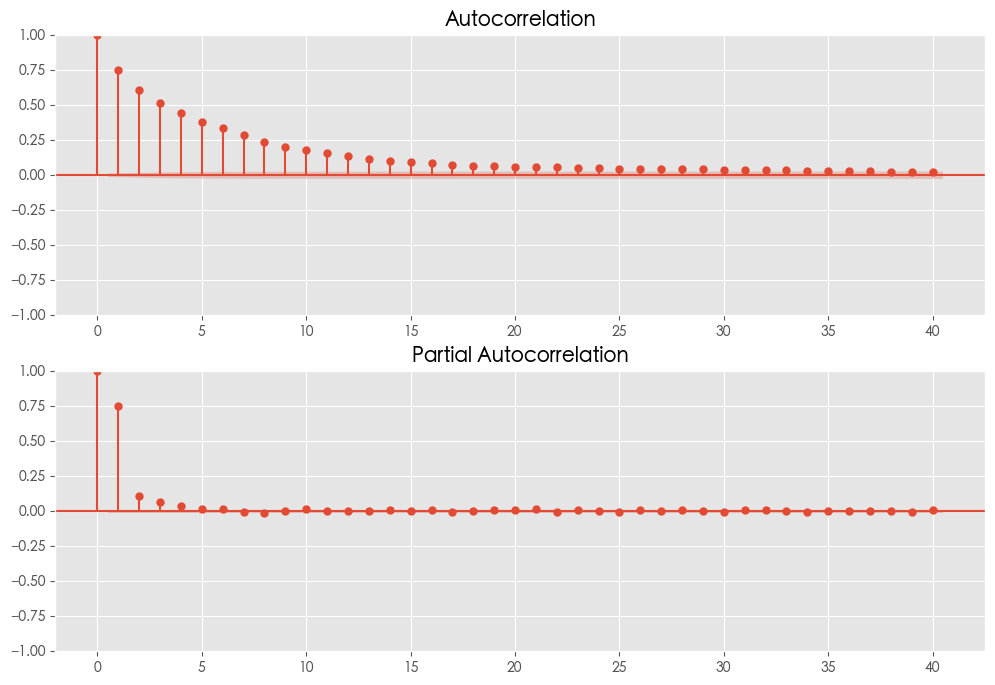

In [7]:
#from acf and pacf we can decide parameter p and q. 
#I may have insufficient understanding towards this part, so it needs further modification
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(tape0701.price,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(tape0701.price,lags=40,ax=ax2)

In [51]:
#normally there are several paramater sets that needs comparing using the following three evaluation metrics, the smaller the better
arma_mod20 = sm.tsa.ARIMA(tape0701_train.price,order = (1,0,0)).fit() # data["xt"]是没有差分的数据
arma_mod30 = sm.tsa.ARIMA(tape0701_train.price,order = (0,0,1)).fit()
arma_mod40 = sm.tsa.ARIMA(tape0701_train.price,order = (1,0,1)).fit()
values = [[arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic],[arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic],[arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic]]
df = pd.DataFrame(values,index=["AR(1,1,0)","MA(0,1,1)","ARMA(1,1,1)"],columns=["AIC","BIC","hqic"])
df

,AIC,BIC,hqic
"AR(1,1,0)",100134.62199,100158.68194,100142.44948
"MA(0,1,1)",107901.40347,107925.46342,107909.23096
"ARMA(1,1,1)",99786.16778,99818.24770,99796.60443


In [52]:
#model fitting
result = sm.tsa.ARIMA(tape0701_train.price, order = (1,0,1)).fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                22471
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -49889.084
Date:                Thu, 15 Feb 2024   AIC                          99786.168
Time:                        13:51:12   BIC                          99818.248
Sample:                             0   HQIC                         99796.604
                              - 22471                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        107.7275      0.081   1325.843      0.000     107.568     107.887
ar.L1          0.8298      0.004    205.770      0.000       0.822       0.838
ma.L1         -0.1789      0.006    -28.014      0.0

In [ ]:
#ARMA model, unavailable for some reason

arma_mod20 = smt.ARMA(tape0701_test.price,(1,0)).fit() 
print(arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic)
arma_mod30 = sm.tsa.ARMA(tape0701_test.price,(0,1)).fit()
print(arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic)
arma_mod40 = sm.tsa.ARMA(tape0701_test.price,(1,1)).fit()
print(arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic)

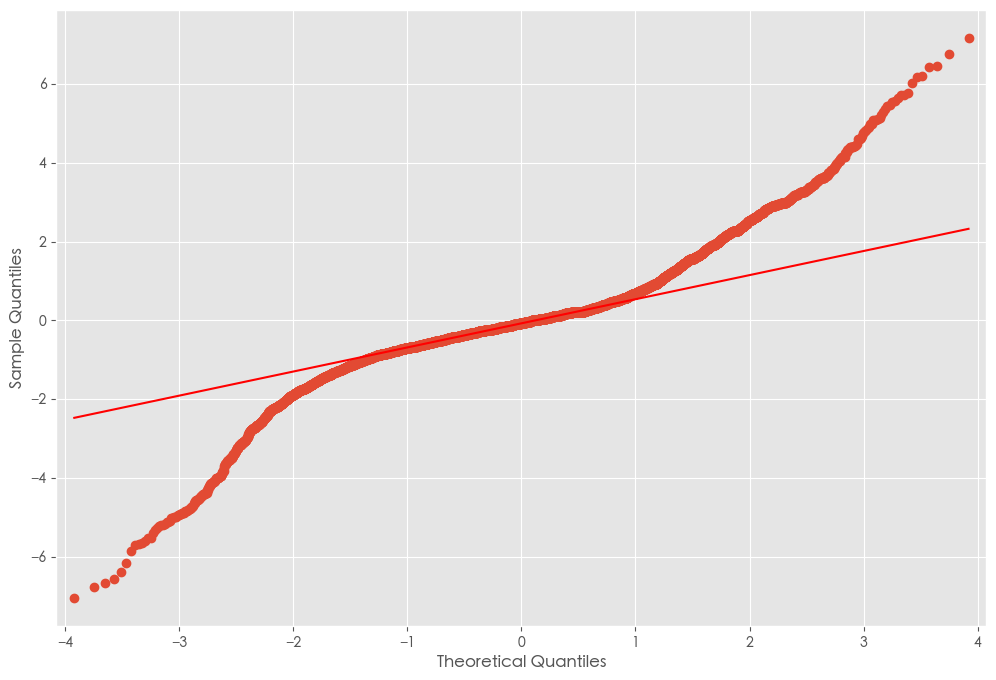

In [53]:
#model evaluation using residual, this is not an ideal outcome
resid = result.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

In [60]:
#prediction
pred = result.predict(22472, 27470,dynamic=True, typ='levels')
print (pred)

22472   105.96081
22473   106.26152
22474   106.51105
22475   106.71810
22476   106.88991
           ...   
27466   107.72754
27467   107.72754
27468   107.72754
27469   107.72754
27470   107.72754
Name: predicted_mean, Length: 4999, dtype: float64


#showprediction
plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
plt.plot(pred)
plt.plot(tape0701_test.price)
plt.show()